# Image Embedding Table API Example

### Table of Contents
* [Overview](#Overview)
* [Set the Environment](#Environment)
* [Generate ImageEmbeddingTable for Siamese Network](#Siamese)
* [Generate ImageEmbeddingTable for Triplet Network](#Triplet)
* [Generate ImageEmbeddingTable for Quartet Network](#Quartet)

## Overview <a id="Overview"></a>

This example illustrates the use of the ImageEmbeddingTable API. Using the API, we create tables for training Siamese Networks, Triplet Networks, and Quartet Networks. Each example uses a directory of dog images separated by dog breed. ImageEmbeddingTables are a convenient way to create data sets for use by Siamese, Triplet, and Quartet Networks. They are similar to ImageTables, except for the number of images (and associated image data, like label) that each observation contains. 

An observation in a Siamese network consists of two images and an indicator that is 1 if the images are dissimilar and 0 if they are similar. An observation for a Triplet network consists of three images: an anchor, a positive image (same class), and a negative image (different class). An observation for a Quartet network consists of 4 images: an anchor, a positive image, and two negative images.

Our data is stored in a path accessible by the CAS server. The data is structured in a directory as follows:
    
../data <br/>
  |--german_shepherd <br/>
  |  |--image1 <br/>
  |  |--image2 <br/>
  |  |--etc.. <br/>
  |--golden_retriever <br/>
  |  |--image1 <br/>
  |  |--image2 <br/>
  |  |--etc.. <br/>
  |--labrador_retriever <br/>
  |  |--image1 <br/>
  |  |--image2 <br/>
  |  |--etc.. <br/>
  |--etc.. <br/>
    
Note: Image data can only be loaded from the server. Client-side loads of image data are unsupported.

## Set the Environment <a id="Environment"></a>
First, set notebook environement by doing the following:
1. Import relevant modules
2. Use matplotlib inline magic so plots render correctly
3. Start a CAS session
4. Load image, deepLearn, datastep action sets to the CAS session

**Remember:** Change _host_name_ and _port_number_ to match your CAS server. You should also have an authinfo (authentication) file set up as well.


In [1]:
import swat
from pprint import pprint

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)


In [3]:
from dlpy.layers import * 
from dlpy.applications import *
from dlpy import Model, Sequential
from dlpy.utils import *
from dlpy.splitting import two_way_split
from dlpy.lr_scheduler import *
from dlpy.images import *
from dlpy.image_embedding import *

In [4]:
s = swat.CAS('host_name', port_number)
s.loadactionset('image')
s.loadactionset('deepLearn')
s.loadactionset('datastep')

NOTE: 'CASUSER(user)' is now the active caslib.
NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'datastep'.


[actionset]

 'datastep'

+ Elapsed: 0.000251s, user: 0.000224s, mem: 0.203mb

# Generate Image Embedding Table for Siamese Network <a id="Siamese"></a>

Now, we will create an ImageEmbeddingTable for a Siamese Network. Essentially, this is an ImageTable that is composed of image pairs and an indicator column that specifies whether the two images are from the same class.

Among other things, we need to specify the data and the model type:

*  **`s`** is the CAS session we want our model to be built in
* **`path`** refers to the ../data directory
* **`label_level`** is an integer that specifies what part of the image path will be used as the image's classification label. Since the path to any of our images is of the form ../data/category/image_name, we want to choose **`label_level_ =-2`** so that 'category' is used for that image's label.
* **`embedding_model`** determines what type of model to build. Other values are triplet and quartet
* **`n_samples`** specifies how many image pairs will be generated
* **`resize_width`** and **`resize_height`** resize all image pairs to the specified states

**Remember:** Change _server_side_data_path_ to the path where your images reside.

In [5]:
my_table= ImageEmbeddingTable.load_files(s, path='server_side_data_path', 
                                         embedding_model_type='siamese', label_level=-2, 
                                         n_samples=128, resize_width=224, resize_height=224)

After creating the embedding table, we will verify:
* The number of image pairs
* The column names
* The channel means of the first image column
* The image summary of the first image column

In [6]:
my_table.numrows()

[numrows]

 127

+ Elapsed: 0.000211s, user: 0.000159s, sys: 4.1e-05s, mem: 0.404mb

In [7]:
my_table.columns

Index(['_id_', '_image_', '_size_', '_path_', '_type_', '_image_1', '_size_1',
       '_path_1', '_type_1', '_fName_', '_label_', '_fName_1', '_label_1',
       '_dissimilar_'],
      dtype='object')

In [8]:
my_table.channel_means

[112.71680880152255, 126.16849226157001, 132.03964015170533]

In [9]:
my_table.image_summary

jpg                   127
minWidth              224
maxWidth              224
minHeight             224
maxHeight             224
meanWidth             224
meanHeight            224
mean1stChannel    112.717
min1stChannel           0
max1stChannel         255
mean2ndChannel    126.168
min2ndChannel           0
max2ndChannel         255
mean3rdChannel     132.04
min3rdChannel           0
max3rdChannel         255
dtype: object

Label frequency returns label information for the two image columns (label, label1) as well as the labels for generated the label pairs (label_pair) and a table that indicates if the images are dissimilar (1) or similar (0).

This information is used as the target to train a Siamese Network Model.

In [10]:
label, label1, label_pair, dissimilar = my_table.label_freq

In [11]:
label

,Level,Frequency
german_shepherd,1,20
golden_retriever,2,18
labrador_retriever,3,29
miniature_poodle,4,27
soft-coated_wheaten_terrier,5,18
toy_poodle,6,15


In [12]:
label1

,Level,Frequency
german_shepherd,1,20
golden_retriever,2,18
labrador_retriever,3,29
miniature_poodle,4,27
soft-coated_wheaten_terrier,5,18
toy_poodle,6,15


In [13]:
label_pair

,Level,Frequency
"german_shepherd,german_shepherd",1,3
"german_shepherd,golden_retriever",2,1
"german_shepherd,labrador_retriever",3,4
"german_shepherd,miniature_poodle",4,4
"german_shepherd,soft-coated_wheaten_terrier",5,3
"german_shepherd,toy_poodle",6,5
"golden_retriever,german_shepherd",7,3
"golden_retriever,golden_retriever",8,2
"golden_retriever,labrador_retriever",9,2
"golden_retriever,miniature_poodle",10,8


In [14]:
dissimilar

,Level,Frequency
0,1,22
1,2,105


Having created the table, we can verify the data looks as expected using a random selection of image pairs.

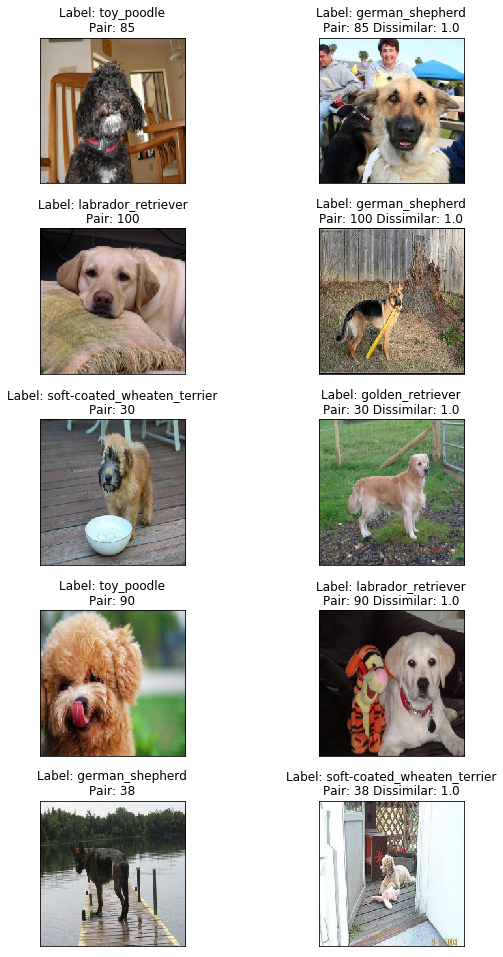

In [15]:
my_table.show(n_image_pairs=5, randomize=True)

We can also use the **`where=`** clause in order to view only image pairs that are disimilar.

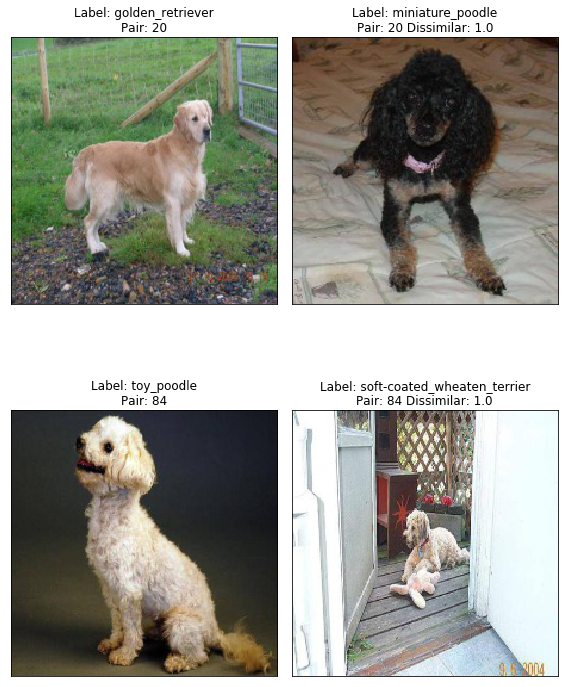

In [16]:
my_table.show(n_image_pairs=2, randomize=True, where='_dissimilar_ = 1')

# Generate Image Embedding Table for Triplet Network <a id="Triplet"></a>

The parameters for generating an image embedding table for a triplet network are the same as for a [Siamese Network](#Siamese) except the parameter _embedding_model_type_ needs to be set to 'triplet'. 

ImageEmbeddingTables built for triplet networks consists image triplets instead of pairs. In each triplet, the first image is an anchor image, the second image is a positive image and the third image is a negative image.

**Remember:** Change _server_side_data_path_ to the path where your images reside.

In [17]:
my_table_triplet = ImageEmbeddingTable.load_files(s, path='server_side_data_path', 
                                         embedding_model_type='triplet', label_level=-2, n_samples=128)

Again, we verify many of the table's features.

In [18]:
my_table_triplet.columns

Index(['_id_', '_image_', '_size_', '_path_', '_type_', '_image_1', '_size_1',
       '_path_1', '_type_1', '_image_2', '_size_2', '_path_2', '_type_2',
       '_fName_', '_label_', '_fName_1', '_label_1', '_fName_2', '_label_2'],
      dtype='object')

Label contains the frequency of anchor images, label1 contains the frequency of positive images, label2 contains the frequency of negative images, and label_triplet contains the frequency of combinations.

In [19]:
label, label1, label2, label_triplet = my_table_triplet.label_freq

In [20]:
label

,Level,Frequency
german_shepherd,1,20
golden_retriever,2,18
labrador_retriever,3,29
miniature_poodle,4,27
soft-coated_wheaten_terrier,5,18
toy_poodle,6,15


Because triplets are specified by a (anchor, positive, negative) format, the first two images of each row should always be the same class and the last image should be different.

In [21]:
label_triplet

,Level,Frequency
"german_shepherd,german_shepherd,golden_retriever",1,3
"german_shepherd,german_shepherd,labrador_retriever",2,4
"german_shepherd,german_shepherd,miniature_poodle",3,2
"german_shepherd,german_shepherd,soft-coated_wheaten_terrier",4,7
"german_shepherd,german_shepherd,toy_poodle",5,4
"golden_retriever,golden_retriever,german_shepherd",6,3
"golden_retriever,golden_retriever,labrador_retriever",7,5
"golden_retriever,golden_retriever,miniature_poodle",8,6
"golden_retriever,golden_retriever,soft-coated_wheaten_terrier",9,2
"golden_retriever,golden_retriever,toy_poodle",10,2


We view a few image triplets to ensure the triplets seem valid. Note yellow labrador retrievers and chocolate labrador retrievers may appear different despite an identical class.

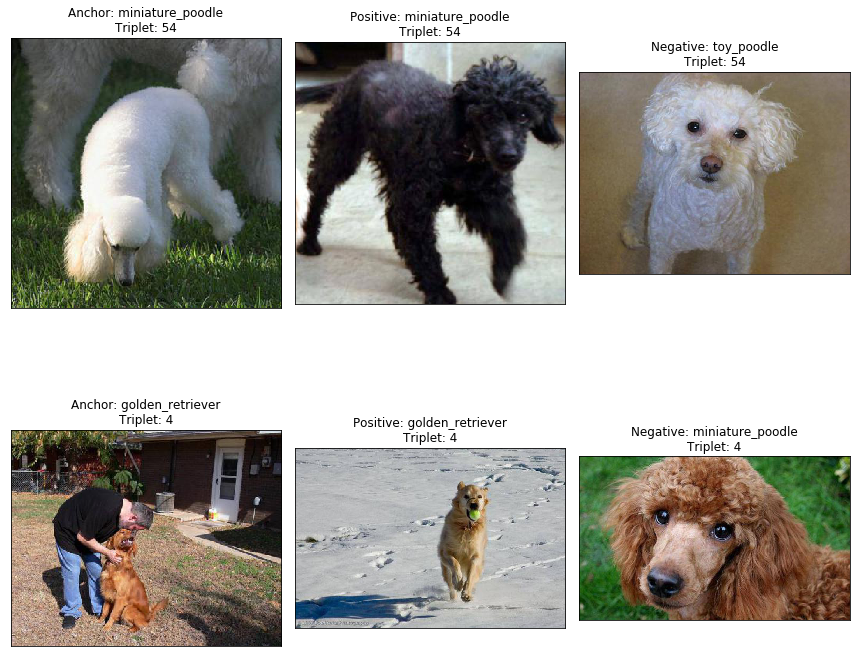

In [22]:
my_table_triplet.show(n_image_pairs=2, randomize=True)

# Generate Image Embedding Table for Quartet Network <a id="Quartet"></a>

The parameters for generating an image embedding table for a quartet network are the same as for a [Siamese Network](#Siamese) except the parameter _embedding_model_type_ needs to be set to 'quartet'.

Quartet models rely are similar to triplet models, but have an additional negative image. Image quartets are therefore composed of (anchor, positive, negative1, negative2). The second negative image is of the same class as the first negative image.

**Remember:** Change _server_side_data_path_ to the path where your images reside.

In [23]:
my_table_quartet = ImageEmbeddingTable.load_files(s, path='server_side_data_path', 
                                                  embedding_model_type='quartet', label_level=-2, 
                                                  n_samples=128, resize_width=224, resize_height=224)

In [24]:
my_table_quartet.columns

Index(['_id_', '_image_', '_size_', '_path_', '_type_', '_image_1', '_size_1',
       '_path_1', '_type_1', '_image_2', '_size_2', '_path_2', '_type_2',
       '_image_3', '_size_3', '_path_3', '_type_3', '_fName_', '_label_',
       '_fName_1', '_label_1', '_fName_2', '_label_2', '_fName_3', '_label_3'],
      dtype='object')

In [25]:
label, label1, label2, label3, label_quartet = my_table_quartet.label_freq

In [26]:
label3

,Level,Frequency
german_shepherd,1,26
golden_retriever,2,19
labrador_retriever,3,15
miniature_poodle,4,16
soft-coated_wheaten_terrier,5,20
toy_poodle,6,31


In [27]:
label_quartet

,Level,Frequency
"german_shepherd,german_shepherd,german_shepherd,german_shepherd",1,2
"german_shepherd,german_shepherd,golden_retriever,golden_retriever",2,4
"german_shepherd,german_shepherd,labrador_retriever,labrador_retriever",3,3
"german_shepherd,german_shepherd,miniature_poodle,miniature_poodle",4,4
"german_shepherd,german_shepherd,soft-coated_wheaten_terrier,soft-coated_wheaten_terrier",5,2
"german_shepherd,german_shepherd,toy_poodle,toy_poodle",6,5
"golden_retriever,golden_retriever,german_shepherd,german_shepherd",7,4
"golden_retriever,golden_retriever,labrador_retriever,labrador_retriever",8,3
"golden_retriever,golden_retriever,miniature_poodle,miniature_poodle",9,4
"golden_retriever,golden_retriever,soft-coated_wheaten_terrier,soft-coated_wheaten_terrier",10,2


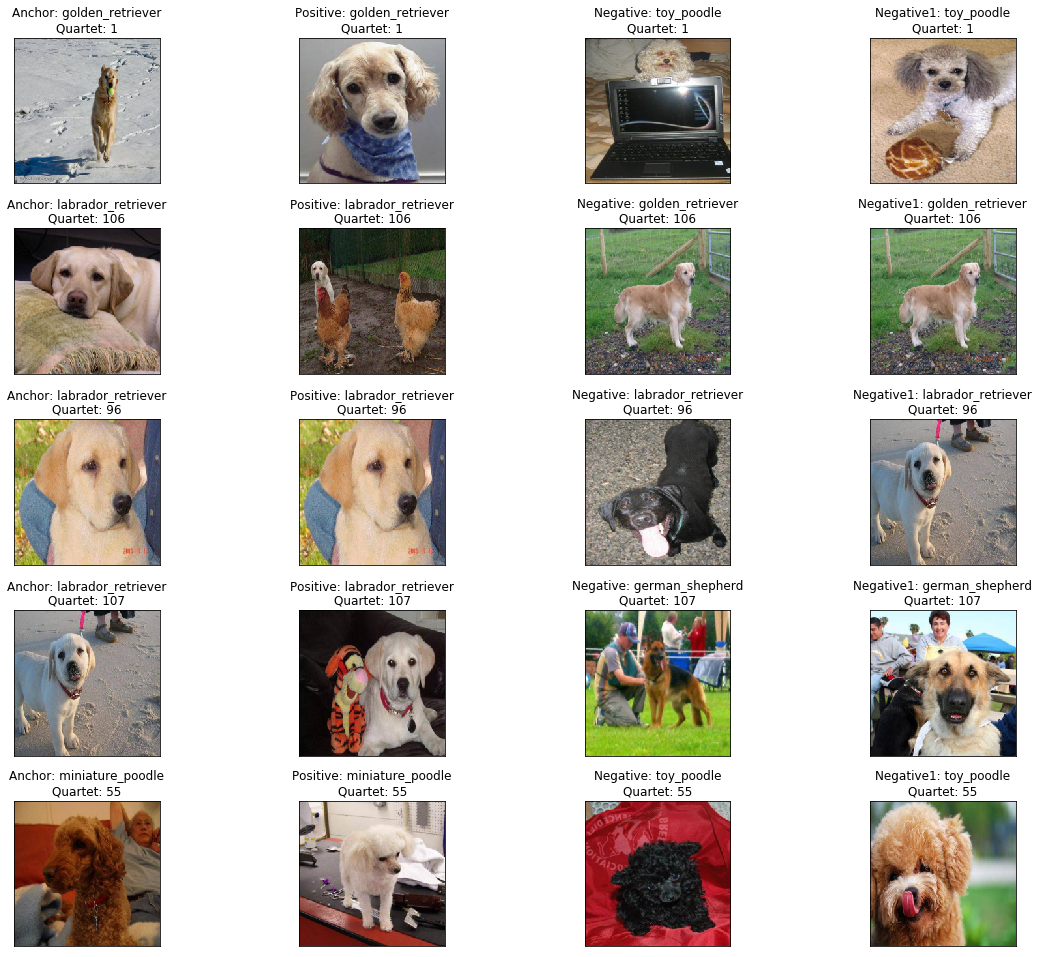

In [28]:
my_table_quartet.show()

Be sure to close the CAS session to free up system resources when you are done.

In [29]:
s.endsession()

+ Elapsed: 9.4e-05s, sys: 8.3e-05s, mem: 0.221mb